In [ ]:
from io import open
import os
import unicodedata
import string
import re
import random
import time
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
csv_file = 'losses.csv'

# Полезные функции

## Подготовка датасета

In [ ]:
# Токен начала последовательности, Start-of-Sequence
SOS_token = 0
# Токен окончания последовательности, End-of-Sequence
EOS_token = 1


class Lang:
    """
    Класс для представления языка, содержащий словарь, состоящий из слов языка и их индексов.

    Атрибуты:
        name (str): название языка.
        word2index (dict): сопоставление слов и их индексов в словаре языка.
        word2count (dict): счётчик количества уникальных слов в словаре.
        index2word (dict): сопоставление индексов и слов в словаре.
        n_words (int): количество уникальных слов в словаре.

    Методы:
        addSentence(self, sentence):
            Добавляет все слова в предложении в словарь.

        addWord(self, word):
            Добавляет слово в словарь.
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS и EOS уже включены в это число как 2 уникальных слова

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Если слово ещё не в словаре
        if word not in self.word2index:
            # Слово добавляется в словарь как ключ и как значение ему присваивается новый индекс = кол-ву уникальных слов в словаре.
            self.word2index[word] = self.n_words
            # В словарь-счётчик, слово опять же добавляется как ключ, и, так как слово встречается первый раз, то ему присваивается счётное значение = 1.
            self.word2count[word] = 1
            # В словарь-сопоставление индекса и слова, индекс, присвоенный ранее, используется как ключ, а само слово становится значением.
            self.index2word[self.n_words] = word
            # Счётчик кол-ва уникальных слов в словаре увеличивается на 1.
            self.n_words += 1
        # Если слово уже присутствует в словаре
        else:
            # У него увеличивается значение в словаре-счётчике.
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    """
    Функция для преобразования строки Unicode в обычные символы ASCII

    Параметры:
        s (str): строка Unicode.

    Возвращает:
        str: входящая строка, нормализованная в символы ASCII.
    """
    # Unicode строка разбивается на символы, согласно правилам NFD (Normalization Form D), все не ASCII части убираются.
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    return s


def normalizeString(s):
    """
    Функция для нормализации строк для задач НЛП

    Параметры:
        s (str): строка текста.

    Возвращает:
        str: входящая строка, нормализованная для задач НЛП.
    """
    # Превращаю все символы в строке в символы, закодированные в ASCII, приводит их к нижнему регистру и убирает пробелы в начале и конце строки.
    s = unicodeToAscii(s.lower().strip())
    # Добавляю пробелы вокруг знаков пунктуации ".!?" чтобы отделить их от остального текста.
    s = re.sub(r"([.!?])", r" \1", s)
    # Заменяю все не-алфавитные символы (исключая группу .!?) и заменяю их пробелами.
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s


In [ ]:
def readLangs(path, lang1, lang2, reverse=False):
    """
    Функция для обработки пар предложений из текстового файла и создания словаря-объекта класса Lang для каждого языка.

    Параметры:
        path (str): путь, по которому располагается текстовый файл, содержащий пары предложений, разделенных табуляцией, на 2х разных языках.
        lang1 (str): название первого языка.
        lang2 (str): название второго языка.
        reverse (bool, optional): флаг, если значение True, то меняет языки местами, и, следовательно, направление перевода.

    Возвращает:
        input_lang (Lang object): объект класса Lang для первого языка - языка, с которого будет осуществляться перевод.
        output_lang (Lang object): объект класса Lang для второго языка - языка, на который будет осуществляться перевод.
        pairs (list): список пар предложений, содержащий кортежи, где первое значение кортежа - предложение первого языка, второе значение кортежа - предложение второго языка.

    """
    print("Обрабатываю строки...")

    # Читаю .txt файл построчно, и каждую строку складываю в список lines.
    with open(path, encoding='utf-8') as f:
        lines = f.readlines()

    # Из каждой строки выделяю первое и второе предложение, нормализую их и складываю как кортеж в список pairs
    pairs = [(normalizeString(s.strip().split('\t')[0]), normalizeString(s.strip().split('\t')[1])) for s in lines]

    # Если флаг reverse = True, меняю местами языки (направление перевода)
    if reverse:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        pairs = [(t, s) for s, t in pairs]  # в списке кортежей нормализованные предложения также меняются местами
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    # В списке pairs, беру каждый кортеж, и заполняю словарь input_lang словами из первого элемента кортежа, а словарь output_lang - словами из второго элемента кортежа
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # Возвращаю словари и и список с парами предложений
    return input_lang, output_lang, pairs

In [ ]:
def filterPair(p, max_length, eng_prefixes):
    """
    Функция, содержащая условия-фильтр для обрезки набора данных.

    Параметры:
        p (tuple): кортеж, содержащий 2 строки.
        max_length (int): максимальная длина предложения в словах.
        eng_prefixes (tuple): кортеж префиксов, с которых должна начинаться первая строка в кортеже p

    Возвращает:
        bool: True, если все условия фильтра соблюдены, в противном случае False
    """
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[0].startswith(eng_prefixes)


def filterPairs(pairs, max_length, eng_prefixes):
    """
    Функция для фильтрации пар предложений с использованием функции-фильтра filterPair().

    Параметры:
        pairs (list): список, содержащий кортежи пар предложений.
        max_length (int): максимальная длина предложения.
        eng_prefixes (tuple): кортеж префиксов, с которых должна начинаться первая строка в кортеже из списка pairs.

    Возвращает:
        list: список, содержащий только те кортежи пар, предложения в которых соответствуют условиям из filterPair().
    """
    return [pair for pair in pairs if filterPair(pair, max_length, eng_prefixes)]


In [ ]:
def prepareData(path, lang1, lang2, filtered=True, reverse=False, max_length=10, eng_prefixes=()):
    """
    Функция для считывания пар предложений из .txt файла и создания словарей-объектов класса Lang для каждого языка.
    Функция также фильтрует пары предложений, используя фильтры из filterPairs(), если filtered=True.

    Параметры:
        path (str): путь, по которому располагается текстовый файл, содержащий пары предложений, разделенных табуляцией, на 2х разных языках.
        lang1 (str): название первого языка.
        lang2 (str): название второго языка.
        filtered (bool, optional): флаг, если значение True, то происходит фильтрация датасета с использованием filterPairs().
        reverse (bool, optional): флаг, если значение True, то меняет языки местами, и, следовательно, направление перевода.
        max_length (int, optional): максимальная длина предложения в словах.
        eng_prefixes (tuple, optional): кортеж префиксов, с которых должна начинаться первая строка в кортеже из списка кортежей пар предложений.
    
    Возвращает:
        input_lang (Lang object): объект класса Lang для первого языка - языка, с которого будет осуществляться перевод.
        output_lang (Lang object): объект класса Lang для второго языка - языка, на который будет осуществляться перевод.
        all_pairs (list): список кортежей, содержащий все пары предложений из текстового файла.
        pairs (list): список кортежей, содержащий только отфильтрованные пары предложений.
    """
    
    # Читаю строки из текстового файла, создаю словари-объекты класса Lang для каждого из 2х языков, создаю список кортежей всех пар предложений.
    input_lang, output_lang, all_pairs = readLangs(path, lang1, lang2, reverse=reverse)
    print(f"Общее число пар предложений: {len(all_pairs)}")
    
    # Если необходимо, фильтрую датасет.
    pairs = all_pairs
    if filtered:
        pairs = filterPairs(all_pairs, max_length, eng_prefixes)
        print(f"Датасет обрезан до {len(pairs)} пар предложений.")
    
    # Вывожу количество уникальных слов в каждом словаре.
    print("Количество слов в словарях:")
    print(input_lang.name, "словарь:", input_lang.n_words)
    print(output_lang.name, "словарь:", output_lang.n_words)
    
    # Возвращаю словари, список всех пар и список отфильтрованных пар.
    return input_lang, output_lang, all_pairs, pairs

In [ ]:
def indexesFromSentence(lang, sentence):
    """
    Функция возвращает список индексов, соответствующих словам в предложении.

    Параметры:
        lang (Lang object): словарь-объект клааса Lang для текущего предложения.
        sentence (str): строка, содержащая предложение.

    Возвращает:
        list: список целых чисел - индексов, соответствующих словам в предложении.
    """
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    """
    Функция возвращает тензор индексов, соответствующих словам в предложении, заканчивающийся индексом токена EOS.

    Параметры:
        lang (Lang object): словарь-объект клааса Lang для текущего предложения.
        sentence (str): строка, содержащая предложение.

    Возвращает:
        Tensor: PyTorch тензор, содержащий индексы слов в предложении и заканчивающийся индексом токена EOS.
    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)  # Добавляю токен EOS как финальный индекс тензора.
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)    # .view(-1, 1) преобразует форму тензора в (seq_len, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    """
    Функция возвращает тензор X (фичи, предложения на языке, с которого делать перевод) и тензор Y (таргеты, предложения на языке, на который делать перевод),
    соответствующие предложениям в кортеже пары предложений из списка кортежей.

    Параметры:
        pair (tuple): кортеж, содержащий 2 строки.
        input_lang (Lang object):  объект класса Lang для языка, с которого будет осуществляться перевод (input, X).
        output_lang (Lang object): объект класса Lang для языка, на который будет осуществляться перевод (output, Y).

    Возвращает:
        tuple: кортеж, содержащий 2 PyTorch тензора, один для входящего предложения (input, X), второй для исходящего предложения (output, Y).
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Обучение

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=25):
    """
    Функция, обучающая кодировщик и декодировщик модель на 1 паре предложений.

    Параметры:
        input_tensor (torch.Tensor): тензор предложения, с которого осуществляется перевод, формы (seq_len, batch_size).
        target_tensor (torch.Tensor): тензор предложения, на которое осуществляется перевод, формы (seq_len, batch_size).
        encoder (torch.nn.Module): модель-кодировщик.
        decoder (torch.nn.Module): модель-декодировщик.
        encoder_optimizer (torch.optim.Optimizer): оптимизатор для кодировщика.
        decoder_optimizer (torch.optim.Optimizer): оптимизатор для декодировщика.
        criterion (torch.nn.Module): функция потерь.
        max_length (int, optional): максимальная длина предложения в словах (25 по умолчанию).

    Возвращает:
        float: среднее значение функции потерь по каждому семплу.
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, pairs, input_lang, output_lang, n_iters, print_every=1000, plot_every=1000, learning_rate=0.01, max_length=25):
    """
    Функция обучает модель-переводчик (схема кодировщик-декодировщик) указанное число итераций, используя произвольным образом выбранную пару предложений.

    Параметры:
        encoder (nn.Module): кодировщик модели.
        decoder (nn.Module): декодировщик модели.
        pairs (list): список, содержащий пары предложений.
        input_lang (Lang): словарь класса Lang для языка, с которого осуществляется перевод.
        output_lang (Lang): словарь класса Lang для языка, на который осуществляется перевод.
        n_iters (int): количество предложений, на которых будет обучаться модель.
        print_every (int): количество итераций для вывода прогресса обучения. По умолчанию 1000.
        plot_every (int): количество итераций для сохранения текущего значения функции потерь. По умолчанию 1000.
        learning_rate (float): скорость обучения для оптимизаторов, по умолчанию 0.01.
        max_length (int): максимальная длина, используемая для паддинга предложений. По умолчанию 25.

    Возвращает:
        list: список, содержащий значения функции потерь каждые `plot_every` итераций.
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0 
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'Time: {timeSince(start, iter/n_iters)} / Step: {iter} / Progress: {iter/n_iters:.0%} / Loss: {print_loss_avg:.4f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(round(plot_loss_avg, 4))
            plot_loss_total = 0
            
    return plot_losses

## Оценка качества работы модели

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=25):
    """ 
    Функция для оценки качества перевода. Принимает предложение, которое надо перевести, и модель, переводит его и возвращает перевод.

    Параметры:
        encoder (EncoderRNN): модель-кодировщик.
        decoder (AttnDecoderRNN): модель-декодировщик.
        sentence (str): предложение для перевода.
        max_length (int): максимальная длина предложения-перевода (по умолчанию 25).

    Возвращает:
        tuple: кортеж, содержащий:
            decoded_words (List[str]): список переведённых слов.
            decoder_attentions (torch.Tensor): тензор, содержащий веса внимания для каждого входного и выходного токена.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Вспомогательные функции

In [ ]:
def asMinutes(s):
    """
    Функция, превращающая секунды в стркоу формата `m s`, где m - кол-во минут, s - кол-во секунд.

    Параметры:
        s (float): продолжительность в секундах.

    Возвращает:
        str: строка, содержащая продолжительность в минутах и секундах.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {int(s)}s'


def timeSince(since, percent):
    """
    Функция, рассчитывающая время, прошедшее с начала обучения, и время, приблизительно оставшееся до окончания обучения.

    Параметры:
        since (float): Unix-время в секундах, представляющее время начала.
        percent (float): доля между 0 и 1, представляющая прогресс обучения.
    
    Возвращает:
        str: строка, содержащая время, прошедшее с начала обучения, и время, приблизительно оставшееся до окончания обучения.
    """
    now = time.time()
    elapsed_time = now - since
    total_duration = elapsed_time / percent
    remaining_time = total_duration - elapsed_time
    return f'elapsed {asMinutes(elapsed_time)}, remained {asMinutes(remaining_time)}'

In [ ]:
def add_loss_columns(csv_file, model_name, new_losses, create_csv=False):
    """
    Функция, добавляющая новый столбец, содержащий значения функции потерь, к уже существующему .csv файлу, или создающая новый .csv файл.

    Параметры:
      csv_file (str): имя .csv файла для хранения результатов обучения моделей.
      model_name (str): имя модели, чьи результаты обучения надо добавить в .csv файл.
      new_losses (list): список, содержащий значения функции потерь текущей модели.
      create_csv (bool): флаг, обозначающий необходимость создания нового .csv файла.

    Возвращает:
      None: функция не возвращает ничего, но экспортирует .csv файл, содержащий результаты обучения.
    """

    if not os.path.exists(csv_file):
        if create_csv:
            df = pd.DataFrame({model_name: new_losses})
            df.to_csv(csv_file, index=False)

        else:
            raise FileNotFoundError(f"'{csv_file}' file not found.")
    else:
        df = pd.read_csv(csv_file)

        if model_name not in df.columns:
            df[model_name] = new_losses
        else:
            df.loc[:, model_name] = new_losses

        df.to_csv(csv_file, index=False)

In [ ]:
def showPlot(df, last_column_only=False, ax=None):
    """
    Функция строит график значений функции потерь, как источник данных используя pandas датафрейм.

    Параметры:
        df (pandas DataFrame): датафрейм, содержащий значения потерь.
        last_column_only (bool): флаг для построения графиков. Если True - строится график только последнего столбца, по умолчанию False.
        ax (Matplotlib Axes, optional): объект оси, на которой надо нарисовать график. Если не указан, будет создана новая фигура.

    Возвращает:
        None: функция ничего не возвращает.
    """
    if ax is None:
        fig, ax = plt.subplots()
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Graph")
    
    if last_column_only:
        ax.plot(df.iloc[:, -1], label=df.columns[-1])
    else:
        for column in df.columns:
            ax.plot(df[column], label=column)

    ax.legend()

# Загрузка и подготовка данных

In [ ]:
!unzip rus-eng.zip
!tail /content/rus.txt
new_path = r"/content/rus.txt"

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              
We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (C

In [ ]:
MAX_LENGTH = 25

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

input_lang, output_lang, all_pairs, filter_pairs = prepareData(new_path, 'eng', 'rus', filtered=True, reverse=False, max_length=MAX_LENGTH, eng_prefixes=eng_prefixes)
print(random.choice(all_pairs))
print(random.choice(filter_pairs))

Обрабатываю строки...
Общее число пар предложений: 467119
Датасет обрезан до 32561 пар предложений.
Количество слов в словарях:
eng словарь: 16854
rus словарь: 57407
('we have not been notified about their change of address .', 'нам не сообщили что у них изменился адрес .')
('she is about forty .', 'еи около сорока лет .')


In [ ]:
print(f"len(all_pairs): {len(all_pairs)}")
print(f"len(filter_pairs): {len(filter_pairs)}")

len(all_pairs): 467119
len(filter_pairs): 32561


# Seq2seq with attention

## Скалярное произведение

### Архитектура

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class ScaledDotAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(ScaledDotAttnDecoderRNN, self).__init__()

        # Инициализирую атрибуты класса
        self.hidden_size = hidden_size       # Гиперпараметр - размер скрытого состояния, одинаковый для эмбеддинга и скрытого состояния GRU-ячейки
        self.output_size = output_size       # Размер словаря языка, на который осуществляется перевод
        self.dropout_p = dropout_p           # Вероятность обнуления весов
        self.max_length = max_length         # Максимальная длина выходного тензора в токенах

        # Слои модели-декодировщика
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size * 2, self.hidden_size)  # Вход в GRU-ячейку - конкатенация эмбеддинга и внимания
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size)    # Линейный слой для векторов Q
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size)    # Линейный слой для векторов K
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size)    # Линейный слой для векторов V
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # Эмбеддинг и дропаут
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Вычисляю вектора Q, K, V и значения внимания
        K = self.Wk(encoder_outputs)
        Q = self.Wq(hidden)
        V = self.Wv(encoder_outputs)
        d_k = self.hidden_size  # масштабирование
        scores = torch.sum(Q * K, dim=-1) / math.sqrt(d_k)  # механизм внимания типа scaled dot-product, со страницы презентации 8

        # Рассчитываю распределение вероятностей слоя attention и применяю к выходу кодировщика
        attn_weights = F.softmax(scores, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), V.unsqueeze(0))

        # Объединяю dense-представление токена и выход слоя внимания, применяю ReLU, провожу через GRU
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = F.relu(output)
        output, hidden = self.gru(output.unsqueeze(0), hidden)

        # Выход через софтмакс
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Обучение

In [ ]:
MAX_LENGTH = 25

hidden_size = 256
encoder_scaled_dot_attn = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_scaled_dot_attn = ScaledDotAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

scaled_dot_attention_losses = trainIters(encoder_scaled_dot_attn, decoder_scaled_dot_attn, filter_pairs, input_lang, output_lang, 
                               100000, print_every=10000, learning_rate=0.01, max_length=MAX_LENGTH)

Time: elapsed 4m 39s, remained 41m 56s / Step: 10000 / Progress: 10% / Loss: 4.2848
Time: elapsed 9m 18s, remained 37m 15s / Step: 20000 / Progress: 20% / Loss: 3.4517
Time: elapsed 13m 58s, remained 32m 37s / Step: 30000 / Progress: 30% / Loss: 3.0214
Time: elapsed 18m 41s, remained 28m 1s / Step: 40000 / Progress: 40% / Loss: 2.7114
Time: elapsed 23m 22s, remained 23m 22s / Step: 50000 / Progress: 50% / Loss: 2.4786
Time: elapsed 28m 3s, remained 18m 42s / Step: 60000 / Progress: 60% / Loss: 2.2681
Time: elapsed 32m 46s, remained 14m 2s / Step: 70000 / Progress: 70% / Loss: 2.1118
Time: elapsed 37m 29s, remained 9m 22s / Step: 80000 / Progress: 80% / Loss: 1.9855
Time: elapsed 42m 11s, remained 4m 41s / Step: 90000 / Progress: 90% / Loss: 1.8664
Time: elapsed 46m 54s, remained 0m 0s / Step: 100000 / Progress: 100% / Loss: 1.7310


### Проверка качества

In [ ]:
model_name = 'scaled_dot_attention'

add_loss_columns(csv_file, model_name, scaled_dot_attention_losses, create_csv=True)

torch.save(encoder_scaled_dot_attn.state_dict(), f'{model_name}_encoder.pt')
torch.save(decoder_scaled_dot_attn.state_dict(), f'{model_name}_decoder.pt')

In [ ]:
evaluateRandomly(encoder_scaled_dot_attn, decoder_scaled_dot_attn, filter_pairs, n=10)

> you re not married are you ?
= ты ведь не замужем ?
< ты ведь не женат ? <EOS>

> we re on the way .
= мы уже едем .
< мы на пути . <EOS>

> you re photogenic .
= ты фотогеничен .
< ты вас . <EOS>

> i m a high school student .
= я учащиися среднеи школы .
< я студент в . . <EOS>

> we re ok .
= мы в порядке .
< мы идем в порядке . <EOS>

> i m going to my sister s .
= я еду к сестре .
< я иду в своеи . <EOS>

> i m well aware of the situation .
= мне хорошо известно о ситуации .
< я прекрасно осознаю . . . . <EOS>

> we re responsible for you .
= мы несем за тебя ответственность .
< мы за тебя очень . <EOS>

> you re an irresponsible idiot .
= ты безответственная идиотка .
< ты безответственныи идиот . <EOS>

> i m already rich .
= я уже богат .
< я уже богата . <EOS>



## MLP

### Архитектура

In [ ]:
class MLPAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(MLPAttnDecoderRNN, self).__init__()

        # Атрибуты те же, что и в прошлой архитектуре
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Слои, эмбеддинг
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # Слой attention, реализация однослойный MLP со страницы 9 презентации
        self.attn = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size),  # Линейный слой для входа
            nn.Tanh(),  # Активация - гиперболический тангенс
            nn.Linear(self.hidden_size, self.max_length),  # Линейный слой для расчёта значений attention
            nn.Softmax(dim=1)  # Софтмакс для распределения вероятностей
        )
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)  # Соединение attention и embedding
        self.dropout = nn.Dropout(self.dropout_p)  # Сброс весов
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)  # GRU
        self.out = nn.Linear(self.hidden_size, self.output_size)  # Выход декодировщика

    def forward(self, input, hidden, encoder_outputs):
        # Эмбеддинг и сброс весов
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Расчёт весов attention, объединение их с входящим вектором, проход через активацию и GRU
        attn_weights = self.attn(torch.cat((embedded[0], hidden[0]), 1))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        # Выход декодировщика
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Обучение

In [ ]:
MAX_LENGTH = 25

hidden_size = 256
encoder_mlp_attn = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_mlp_attn = MLPAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

mlp_attention_losses = trainIters(encoder_mlp_attn, decoder_mlp_attn, filter_pairs, input_lang, output_lang, 
                               100000, print_every=10000, learning_rate=0.01, max_length=MAX_LENGTH)

Time: elapsed 4m 37s, remained 41m 41s / Step: 10000 / Progress: 10% / Loss: 4.2647
Time: elapsed 9m 13s, remained 36m 55s / Step: 20000 / Progress: 20% / Loss: 3.4384
Time: elapsed 13m 53s, remained 32m 24s / Step: 30000 / Progress: 30% / Loss: 2.9784
Time: elapsed 18m 35s, remained 27m 53s / Step: 40000 / Progress: 40% / Loss: 2.6910
Time: elapsed 23m 17s, remained 23m 17s / Step: 50000 / Progress: 50% / Loss: 2.4613
Time: elapsed 28m 0s, remained 18m 40s / Step: 60000 / Progress: 60% / Loss: 2.2840
Time: elapsed 32m 43s, remained 14m 1s / Step: 70000 / Progress: 70% / Loss: 2.0944
Time: elapsed 37m 26s, remained 9m 21s / Step: 80000 / Progress: 80% / Loss: 1.9975
Time: elapsed 42m 9s, remained 4m 41s / Step: 90000 / Progress: 90% / Loss: 1.8901
Time: elapsed 46m 52s, remained 0m 0s / Step: 100000 / Progress: 100% / Loss: 1.7862


### Проверка качества

In [ ]:
model_name = 'mlp_attention'

add_loss_columns(csv_file, model_name, mlp_attention_losses, create_csv=False)

torch.save(encoder_mlp_attn.state_dict(), f'{model_name}_encoder.pt')
torch.save(decoder_mlp_attn.state_dict(), f'{model_name}_decoder.pt')

In [ ]:
evaluateRandomly(encoder_mlp_attn, decoder_mlp_attn, filter_pairs, n=10)

> he s afraid i ll get lost .
= он боится что я потеряюсь .
< я что что он . <EOS>

> you re so rude .
= вы такие грубые .
< ты такои грубыи . <EOS>

> i m not going to do that today .
= я не собираюсь делать это сегодня .
< я не собираюсь делать это делать . <EOS>

> i m taking a walk in a park .
= я гуляю в парке .
< я в в в . . <EOS>

> you re the only one i can be myself with .
= ты единственная с кем я могу быть самим собои .
< ты единственная я могу быть собои . <EOS>

> i m sorry tom . i can t do this .
= извини том . я не могу этого сделать .
< я сожалею . я не могу этого сделать . <EOS>

> i m glad someone told me .
= я рад что мне сказали .
< я рад что я меня сказал . <EOS>

> we re vegans .
= мы веганы .
< мы в . . <EOS>

> i m in none of the pictures because i took them .
= меня нет ни на одном из этих фото потому что я их снимала .
< я на два на не . . <EOS>

> i m not going to tell you my name .
= я не собираюсь говорить тебе как меня зовут .
< я не собираюсь говорить вам

# Выводы

In [ ]:
df = pd.read_csv(csv_file)

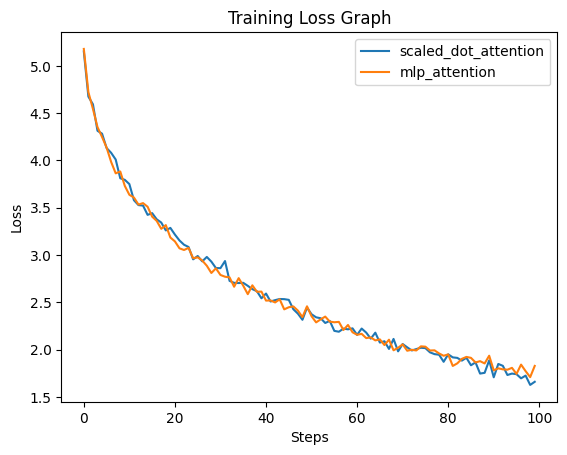

In [ ]:
showPlot(df)

В целом, учитывая, что я реализовала MLP как было написано в презентации - однослойным персептроном, я бы сказала, что из-за того, что я использовала предложения не длиннее 25 токенов, а также определённой структуры, scaled dot-product механизм показал себя немного лучше в плане перспективности. MLP же оказался более стабилен.

Если говорить об изменениях:
- Работа с неурезанным датасетом.
- Работа с батчами.
- Сравнительные данные по модели без attention были бы также кстати.